In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%matplotlib inline

import seaborn as sns
sns.set_style("ticks")
sns.set_context(context='paper',font_scale=1.2)
sns.despine()

import yaml
import os
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings('ignore')

<Figure size 432x288 with 0 Axes>

In [20]:
tasks = ['hospital_mortality','sepsis','LOS_7','readmission_30','hyperkalemia_lab_mild_label','hyperkalemia_lab_moderate_label','hyperkalemia_lab_severe_label','hyperkalemia_lab_abnormal_label','hypoglycemia_lab_mild_label','hypoglycemia_lab_moderate_label','hypoglycemia_lab_severe_label','hypoglycemia_lab_abnormal_label','neutropenia_lab_mild_label','neutropenia_lab_moderate_label','neutropenia_lab_severe_label','hyponatremia_lab_mild_label','hyponatremia_lab_moderate_label','hyponatremia_lab_severe_label','hyponatremia_lab_abnormal_label','aki_lab_aki1_label','aki_lab_aki2_label','aki_lab_aki3_label','aki_lab_abnormal_label','anemia_lab_mild_label','anemia_lab_moderate_label','anemia_lab_severe_label','anemia_lab_abnormal_label','thrombocytopenia_lab_mild_label','thrombocytopenia_lab_moderate_label','thrombocytopenia_lab_severe_label','thrombocytopenia_lab_abnormal_label']
metrics = ['auc', 'auprc', 'ace_abs_logistic_logit']
model_path = '/local-scratch/nigam/projects/jlemmon/transfer_learning/experiments/artifacts/models'
results_path = '/local-scratch/nigam/projects/jlemmon/transfer_learning/experiments/artifacts/results'
figure_path = '/local-scratch/nigam/projects/jlemmon/transfer_learning/experiments/notebooks/figures'

best_clmbr_params = {'all':'gru_sz_800_do_0_lr_0.0001_l2_0', 'mix':'gru_sz_800_do_0_lr_0.0001_l2_0'}

models = ['lr']
feat_groups = ['shared', 'pediatric', 'adult']
cohort_types = ['pediatric', 'adult']

titles = {'hospital_mortality':'In-hospital\nMortality', 'sepsis':'SEPSIS-3', 'LOS_7':'Length of Stay\n> 7 days', 'icu_admission':'Admission to\nICU', 'readmission_30':'Readmission\nafter 30 days', 'aki1_label':'Acute Kidney\nInjury 1','aki2_label':'Acute Kidney\nInjury 2','hg_label':'Hypoglycemia','np_500_label':'Neutropenia\n<500','np_1000_label':'Neutropenia\n<1000'}

In [15]:
y_axis = {
    'auc':{
        'lim':[-0.35,0.1],
        'label':'AUROC'
    },
    'auprc':{
        'lim':[-0.32,0.18],
        'label':'AUPRC'
    },
    'ace_abs_logistic_logit':{
        'lim':[-0.02, 0.15],
        'label':'Calibration'
    }
}

dot_shapes = {
    'PT-LR':'o',
    'FT-LR':'*',
    'PT-GBM':'s',
    'FT-GBM':'D',
    'PT-CLMBR':'^',
    'FT-CLMBR':'p'
}

dot_colours = {
    'pediatric_pretrained':'purple',
    'adult_pretrained':'blue',
    'mixed_pretrained':'darkorange',
    'all_pretrained':'red',
    'pediatric_finetuned':'yellow',
    'adult_finetuned':'black',
    'mixed_finetuned':'brown',
    'all_finetuned':'green'
}

bg_colours = {
    'hospital_mortality':'lightgray', 
    'sepsis': 'royalblue',
    'LOS_7':'red', 
    'icu_admission':'sienna', 
    'readmission_30':'orange', 
    'aki1_label':'darkkhaki',
    'aki2_label':'chartreuse',
    'hg_label':'deepskyblue', 
    'np_500_label':'deeppink', 
    'np_1000_label':'purple'
}

In [30]:
# Get baseline model
lr_df = pd.DataFrame()
for task in tasks:
    for trc in ['adult', 'pediatric']:
        for tstc in ['pediatric']: # 'adult']:
            for fg in feat_groups:
                df = pd.read_csv(f'{results_path}/lr/{task}/tr_{trc}_tst_{tstc}/shared_feats/best/test_eval.csv')
                df['task'] = task
                df['train_cohort'] = trc
                df['test_cohort'] = tstc
                df['cohort'] = ct
                df['model'] = 'LR'
                df['feature_group'] = fg
                lr_df = pd.concat([lr_df,df])

# ft_lr_df = pd.DataFrame()
# for task in tasks:
#     for trc in ['adult', 'pediatric']:
#         for tstc in ['pediatric']: # 'adult']:
#             for fg in feat_groups:
#                 df = pd.read_csv(f'{results_path}/lr_ft/{task}/tr_{trc}_tst_{tstc}/shared_feats/best/test_eval.csv')
#                 df['task'] = task
#                 df['cohort'] = ct
#                 df['model'] = 'FT-LR'
#                 df['feature_group'] = fg
#                 ft_lr_df = pd.concat([ft_lr_df,df])

# pt_gbm_df = pd.DataFrame()
# for ct in cohort_types:
#     for task in tasks:
#         for fg in feat_groups:
#             df = pd.read_csv(f'{results_path}/{ct}/gbm/{task}/{fg}_feats/best/test_eval.csv')
#             df['task'] = task
#             df['cohort'] = ct
#             df['model'] = 'PT-GBM'
#             df['feature_group'] = fg
#             pt_gbm_df = pd.concat([pt_gbm_df,df])
            
# ft_gbm_df = pd.DataFrame()
# for ct in ['adult']:
#     for task in tasks:
#         for fg in feat_groups:
#             df = pd.read_csv(f'{results_path}/{ct}/gbm_ft/{task}/{fg}_feats/best/test_eval.csv')
#             df['task'] = task
#             df['cohort'] = ct
#             df['model'] = 'FT-GBM'
#             df['feature_group'] = fg
#             ft_gbm_df = pd.concat([ft_gbm_df,df])

# pt_clmbr_df = pd.DataFrame()
# for task in tasks:
#     for ct in ['all', 'ad']:#, 'mix', 'ad', 'ped']:
#         for tr_ad in ['ad']:
#             for tst_ad in ['ped']:
#                 for lr in ['0.0001', '1e-5']:
#                     try:
#                         df = pd.read_csv(f'{results_path}/clmbr/pretrained/{ct}/{task}/tr_{tr_ad}_tst_{tst_ad}/gru_sz_800_do_0_lr_{lr}_l2_0/eval.csv')
#                         df['task'] = task
#                         df['cohort'] = ct
#                         df['train_adapter'] = tr_ad
#                         df['test_adapter'] = tst_ad
#                         df['model'] = 'PT-CLMBR'
#                         pt_clmbr_df = pd.concat([pt_clmbr_df,df])
#                     except:
#                         print(f'missing pt {task} eval')
# ft_clmbr_df = pd.DataFrame()
# for task in tasks:
#     for ct in ['all', 'ad']:#, 'mix', 'ad', 'ped']:
#         for tr_ad in ['ped']:
#             for tst_ad in ['ped']:
#                 for lr in ['0.0001', '1e-5']:
#                     try:
#                         df = pd.read_csv(f'{results_path}/clmbr/finetuned/{ct}/{task}/tr_{tr_ad}_tst_{tst_ad}/gru_sz_800_do_0_lr_{lr}_l2_0/eval.csv')
#                         df['task'] = task
#                         df['cohort'] = ct
#                         df['train_adapter'] = tr_ad
#                         df['test_adapter'] = tst_ad
#                         df['model'] = 'FT-CLMBR'
#                         ft_clmbr_df = pd.concat([ft_clmbr_df,df])
#                     except:
#                         print(f'missing ft {task} eval')
                
# pt_clmbr_df = pt_clmbr_df.replace({'metric':{'ace_abs_logistic_log':'ace_abs_logistic_logit', 'ace_rmse_logistic_log':'ace_rmse_logistic_logit'}})
# ft_clmbr_df = ft_clmbr_df.replace({'metric':{'ace_abs_logistic_log':'ace_abs_logistic_logit', 'ace_rmse_logistic_log':'ace_rmse_logistic_logit'}})

In [34]:
lr_df.query("metric=='auc' and feature_group=='shared' and train_cohort=='adult'")
#pt_clmbr_df.query("phase=='test'  and task=='aki2_label'")

,metric,performance,C,model,task,train_cohort,test_cohort,cohort,feature_group
0,auc,0.886822,0.01,LR,hospital_mortality,adult,pediatric,ad,shared
0,auc,0.700919,0.01,LR,sepsis,adult,pediatric,ad,shared
0,auc,0.746834,0.01,LR,LOS_7,adult,pediatric,ad,shared
0,auc,0.732732,0.01,LR,readmission_30,adult,pediatric,ad,shared
0,auc,0.744807,0.01,LR,hyperkalemia_lab_mild_label,adult,pediatric,ad,shared
0,auc,0.802327,0.01,LR,hyperkalemia_lab_moderate_label,adult,pediatric,ad,shared
0,auc,0.857651,0.01,LR,hyperkalemia_lab_severe_label,adult,pediatric,ad,shared
0,auc,0.757441,0.01,LR,hyperkalemia_lab_abnormal_label,adult,pediatric,ad,shared
0,auc,0.749205,0.01,LR,hypoglycemia_lab_mild_label,adult,pediatric,ad,shared
0,auc,0.756785,0.01,LR,hypoglycemia_lab_moderate_label,adult,pediatric,ad,shared


In [52]:
df = ft_gbm_df
for task in tasks:
    t_df = df.query("test_group=='test' and metric=='auc' and feature_group=='shared' and task==@task and cohort=='adult'")
    print(task)
    print(f"{round(t_df['CI_med'].values[0],3)}\n({round(t_df['CI_lower'].values[0],3)}, {round(t_df['CI_upper'].values[0],3)})")

hospital_mortality
0.972
(0.962, 0.98)
sepsis
0.832
(0.798, 0.862)
LOS_7
0.929
(0.923, 0.935)
readmission_30
0.744
(0.717, 0.768)
aki1_label
0.962
(0.953, 0.969)
aki2_label
0.965
(0.95, 0.975)
hg_label
0.854
(0.838, 0.87)
np_500_label
0.976
(0.959, 0.988)
np_1000_label
0.968
(0.955, 0.979)


In [50]:
df = pt_clmbr_df
for cohort in ['all', 'mix']: # 'ad', 'ped']
    print(cohort)
    for task in tasks:
        t_df = df.query("phase=='test' and metric=='auc' and task==@task and cohort==@cohort")
        print(task)
        print(f"{round(t_df['CI_med'].values[0],3)} ({round(t_df['CI_lower'].values[0],3)}, {round(t_df['CI_upper'].values[0],3)})")

all
hospital_mortality
0.984 (0.978, 0.989)
sepsis
0.792 (0.75, 0.835)
LOS_7
0.9 (0.892, 0.906)
readmission_30
0.747 (0.721, 0.771)
aki1_label
0.919 (0.894, 0.941)
aki2_label
0.931 (0.901, 0.958)
hg_label
0.815 (0.799, 0.831)
np_500_label
0.96 (0.921, 0.984)
np_1000_label
0.937 (0.906, 0.962)
mix
hospital_mortality
0.979 (0.959, 0.989)
sepsis
0.841 (0.803, 0.873)
LOS_7
0.939 (0.935, 0.944)
readmission_30
0.759 (0.735, 0.784)
aki1_label
0.857 (0.818, 0.888)
aki2_label
0.425 (0.386, 0.471)
hg_label
0.83 (0.813, 0.845)
np_500_label
0.955 (0.913, 0.984)
np_1000_label
0.848 (0.795, 0.898)


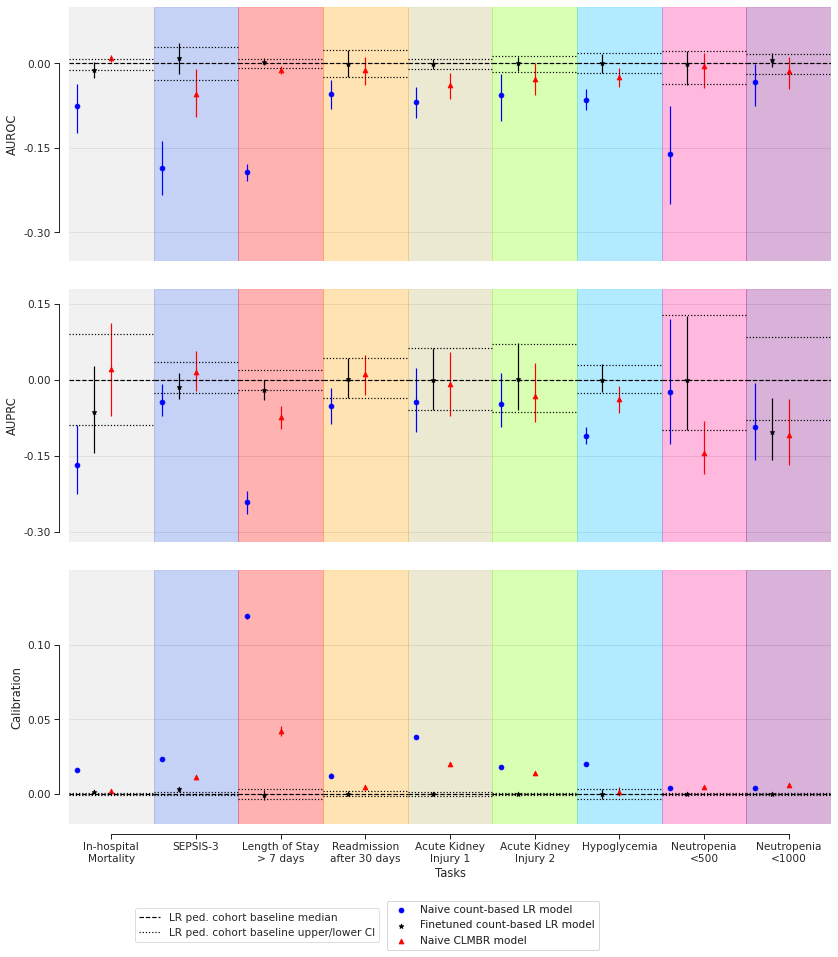

In [58]:
# For each task plot baseline vs CL
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(12,15))
plt.tight_layout(w_pad=1,h_pad=0.5,rect=[0.05,0.15,1,0.95])

fg = 'shared'

for r, metric in enumerate(metrics):
    for c, task in enumerate(tasks):
        legend = []
        legend_text = []
        col_num = 0.6
        axes[r].axvspan(c+0.5, c+1.5,0,1,color=bg_colours[task], alpha=0.3)
        
        bl_lr_evals = bl_lr_df.query('task==@task and metric==@metric and feature_group==@fg and cohort=="pediatric"')
        
        # Pretrained adult-cohort logistic regression model
        pt_lr_evals = bl_lr_df.query('task==@task and metric==@metric and feature_group==@fg and cohort=="adult"')
        pt_lr_evals['CI_upper'] = (pt_lr_evals['CI_upper'] - pt_lr_evals['CI_med']).abs()
        pt_lr_evals['CI_lower'] = (pt_lr_evals['CI_med'] - pt_lr_evals['CI_lower']).abs()
        pt_lr_evals['CI_med'] = pt_lr_evals['CI_med'] - bl_lr_evals['CI_med']
        
        pt_lr_line = axes[r].scatter(
            c+0.6,
            pt_lr_evals['CI_med'],
            color = dot_colours['adult_pretrained'],
            marker = dot_shapes['PT-LR']
        )
        legend.append(pt_lr_line)
        legend_text.append('Naive count-based LR model')
        axes[r].errorbar(
            c+0.6,
            pt_lr_evals['CI_med'],
            pt_lr_evals[['CI_lower', 'CI_upper']].values.T,
            color = dot_colours['adult_pretrained']
        )
        
        # Finetuned adult-cohort logistic regression model
        ft_lr_evals = ft_lr_df.query('task==@task and metric==@metric and feature_group==@fg and cohort=="adult"')
        ft_lr_evals['CI_upper'] = (ft_lr_evals['CI_upper'] - ft_lr_evals['CI_med']).abs()
        ft_lr_evals['CI_lower'] = (ft_lr_evals['CI_med'] - ft_lr_evals['CI_lower']).abs()
        ft_lr_evals['CI_med'] = ft_lr_evals['CI_med'] - bl_lr_evals['CI_med']
        
        ft_lr_line = axes[r].scatter(
            c+0.8,
            ft_lr_evals['CI_med'],
            color = dot_colours['adult_finetuned'],
            marker = dot_shapes['FT-LR']
        )
        legend.append(ft_lr_line)
        legend_text.append('Finetuned count-based LR model')
        axes[r].errorbar(
            c+0.8,
            ft_lr_evals['CI_med'],
            ft_lr_evals[['CI_lower', 'CI_upper']].values.T,
            color = dot_colours['adult_finetuned']
        )
        
#         # Pretrained adult-cohort GBM model
#         pt_gbm_evals = pt_gbm_df.query('task==@task and metric==@metric and feature_group==@fg and cohort=="adult"')
#         pt_gbm_evals['CI_upper'] = (pt_gbm_evals['CI_upper'] - pt_gbm_evals['CI_med']).abs()
#         pt_gbm_evals['CI_lower'] = (pt_gbm_evals['CI_med'] - pt_gbm_evals['CI_lower']).abs()
#         pt_gbm_evals['CI_med'] = pt_gbm_evals['CI_med'] - bl_lr_evals['CI_med']

#         pt_gbm_line = axes[r].scatter(
#             c+0.8,
#             pt_gbm_evals['CI_med'],
#             color = dot_colours['adult_pretrained'],
#             marker = dot_shapes['PT-GBM']
#         )
#         legend.append(pt_gbm_line)
#         legend_text.append('PT adult-cohort lightGBM model')
#         axes[r].errorbar(
#             c+0.8,
#             pt_gbm_evals['CI_med'],
#             pt_gbm_evals[['CI_lower', 'CI_upper']].values.T,
#             color = dot_colours['adult_pretrained']
#         )
        
#         # Finetuned adult-cohort GBM model
#         ft_gbm_evals = ft_gbm_df.query('task==@task and metric==@metric and feature_group==@fg and cohort=="adult"')
#         ft_gbm_evals['CI_upper'] = (ft_gbm_evals['CI_upper'] - ft_gbm_evals['CI_med']).abs()
#         ft_gbm_evals['CI_lower'] = (ft_gbm_evals['CI_med'] - ft_gbm_evals['CI_lower']).abs()

#         ft_gbm_evals['CI_med'] = ft_gbm_evals['CI_med'] - bl_lr_evals['CI_med']

#         ft_gbm_line = axes[r].scatter(
#             c+0.8,
#             ft_gbm_evals['CI_med'],
#             color = dot_colours['adult_finetuned'],
#             marker = dot_shapes['FT-GBM']
#         )
#         legend.append(ft_gbm_line)
#         legend_text.append('FT adult-cohort lightGBM model')
#         axes[r].errorbar(
#             c+0.8,
#             ft_gbm_evals['CI_med'],
#             ft_gbm_evals[['CI_lower', 'CI_upper']].values.T,
#             color = dot_colours['adult_finetuned']
#         )
         
        # Pretrained all-cohort CLMBR model
        pt_all_clmbr_evals = pt_clmbr_df.query('task==@task and metric==@metric and phase=="test" and cohort=="all"')

        pt_all_clmbr_evals['CI_upper'] = (pt_all_clmbr_evals['CI_upper'] - pt_all_clmbr_evals['CI_med']).abs()
        pt_all_clmbr_evals['CI_lower'] = (pt_all_clmbr_evals['CI_med'] - pt_all_clmbr_evals['CI_lower']).abs()
        pt_all_clmbr_evals['CI_med'] = pt_all_clmbr_evals['CI_med'].values[0] - bl_lr_evals['CI_med'].values[0]

        pt_all_clmbr_line = axes[r].scatter(
            c+1.0,
            pt_all_clmbr_evals['CI_med'],
            color = dot_colours['all_pretrained'],
            marker = dot_shapes['PT-CLMBR']
        )
        legend.append(pt_all_clmbr_line)
        legend_text.append('Naive CLMBR model')
        axes[r].errorbar(
            c+1.0,
            pt_all_clmbr_evals['CI_med'],
            pt_all_clmbr_evals[['CI_lower', 'CI_upper']].values.T,
            color = dot_colours['all_pretrained']
        )

#         # Pretrained adult-cohort CLMBR model
#         pt_mix_clmbr_evals = pt_clmbr_df.query('task==@task and metric==@metric and phase=="test" and cohort=="mix"')
#         pt_mix_clmbr_evals['CI_upper'] = (pt_mix_clmbr_evals['CI_upper'] - pt_mix_clmbr_evals['CI_med']).abs()
#         pt_mix_clmbr_evals['CI_lower'] = (pt_mix_clmbr_evals['CI_med'] - pt_mix_clmbr_evals['CI_lower']).abs()
#         pt_mix_clmbr_evals['CI_med'] = pt_mix_clmbr_evals['CI_med'].values[0] - bl_lr_evals['CI_med'].values[0]

#         pt_mix_clmbr_line = axes[r].scatter(
#             c+1.2,
#             pt_mix_clmbr_evals['CI_med'],
#             color = dot_colours['mixed_pretrained'],
#             marker = dot_shapes['PT-CLMBR']
#         )
#         legend.append(pt_mix_clmbr_line)
#         legend_text.append('PT mix-cohort CLMBR model')
#         axes[r].errorbar(
#             c+1.2,
#             pt_mix_clmbr_evals['CI_med'],
#             pt_mix_clmbr_evals[['CI_lower', 'CI_upper']].values.T,
#             color = dot_colours['mixed_pretrained']
#         )

#         # Finetuned adult-cohort CLMBR model
#         ft_clmbr_evals = ft_clmbr_evals.query('task==@task and metric==@metric and cohort=="adult"')
#         ft_clmbr_evals['CI_upper'] = (ft_clmbr_evals['CI_upper'] - ft_clmbr_evals['CI_med']).abs()
#         ft_clmbr_evals['CI_lower'] = (ft_clmbr_evals['CI_med'] - ft_clmbr_evals['CI_lower']).abs()
#         ft_clmbr_evals['CI_med'] = ft_clmbr_evals['CI_med'] - bl_lr_evals['CI_med']

#         ft_clmbr_line = axes[r].scatter(
#             c+1.0,
#             ft_clmbr_evals['CI_med'],
#             color = dot_colours['adult'],
#             marker = dot_shapes['FT-CLMBR']
#         )
#         legend.append(ft_clmbr_line)
#         legend_text.append('FT adult-cohort CLMBR model')
#         axes[r].errorbar(
#             c+1.0,
#             ft_clmbr_evals['CI_med'],
#             ft_clmbr_evals[['CI_lower', 'CI_upper']].values.T,
#             color = dot_colours['adult']
#         )

        bl_lr_evals['CI_upper'] = (bl_lr_evals['CI_upper'] - bl_lr_evals['CI_med']).abs()
        bl_lr_evals['CI_lower'] = (bl_lr_evals['CI_med'] - bl_lr_evals['CI_lower']).abs()
        bl_lr_evals['CI_med'] = bl_lr_evals['CI_med'] - bl_lr_evals['CI_med']

        bl_line = axes[r].plot([c+0.5, c+1.5],[bl_lr_evals['CI_med'], bl_lr_evals['CI_med']], linestyle='dashed', color='black')
        axes[r].plot([c+0.5, c+1.5],[bl_lr_evals['CI_upper'], bl_lr_evals['CI_upper']], linestyle='dotted', color='black')
        axes[r].plot([c+0.5, c+1.5],[-bl_lr_evals['CI_lower'], -bl_lr_evals['CI_lower']], linestyle='dotted', color='black')

        plt.xticks(np.arange(1,len(tasks)+1,1))
        axes[r].set_ylim(y_axis[metric]['lim'])
        axes[r].set_xlim([0.5,len(tasks)+0.5])
        axes[r].yaxis.set_major_locator(MaxNLocator(nbins=4,prune='both'))
        axes[r].grid(which='major', linewidth=0.5, axis='y')
        if r == 0:
            axes[r].set_title('')
        if r == len(metrics) - 1:
            axes[r].set_xlabel('Tasks')
            axes[r].set_xticklabels(labels=[titles[t] for t in tasks])
        else:
            axes[r].set_xticklabels('')
            axes[r].set_xlabel('')
            axes[r].spines['bottom'].set_color('white')
            axes[r].tick_params(axis='x', length=0)  
        axes[r].set_ylabel(y_axis[metric]['label'])
        axes[r].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


bl_leg = [Line2D([0],[0], linestyle='dashed', color='black'),
                Line2D([0],[0], linestyle='dotted', color='black')] 
bl_leg_lbls = ['LR ped. cohort baseline median', 'LR ped. cohort baseline upper/lower CI']
bl_legend = plt.legend(bl_leg, bl_leg_lbls, bbox_to_anchor=(0.08,-0.45,0.1,0.1), loc="center left")
plt.gca().add_artist(bl_legend)

cmp_legend = plt.legend(legend, legend_text, bbox_to_anchor=(0.41,-0.45,0.1,0.1), loc="center left")
plt.gca().add_artist(cmp_legend)


sns.despine(offset=10, trim=True,)


plt.savefig('figures/lr_comp_bl.png', bbox_inches='tight')
plt.show()
# remove gbm, separate count vs clmbr and naive vs finetuned
# 

In [ ]:
#wilson cox test LR vs CLMBR and Naive vs Finetuned

In [59]:
lr_naive = bl_lr_df.query("test_group=='test' and metric=='auc' and feature_group=='shared' and cohort=='adult'")

In [62]:
list(lr_naive['CI_med'])

[0.8981049510783974,
 0.6606752033449841,
 0.7185559355352646,
 0.7046022134951007,
 0.6436714812197386,
 0.8895401813324801,
 0.9015065157128423,
 0.7753034516242938,
 0.803180357678922,
 0.9175404542941856]

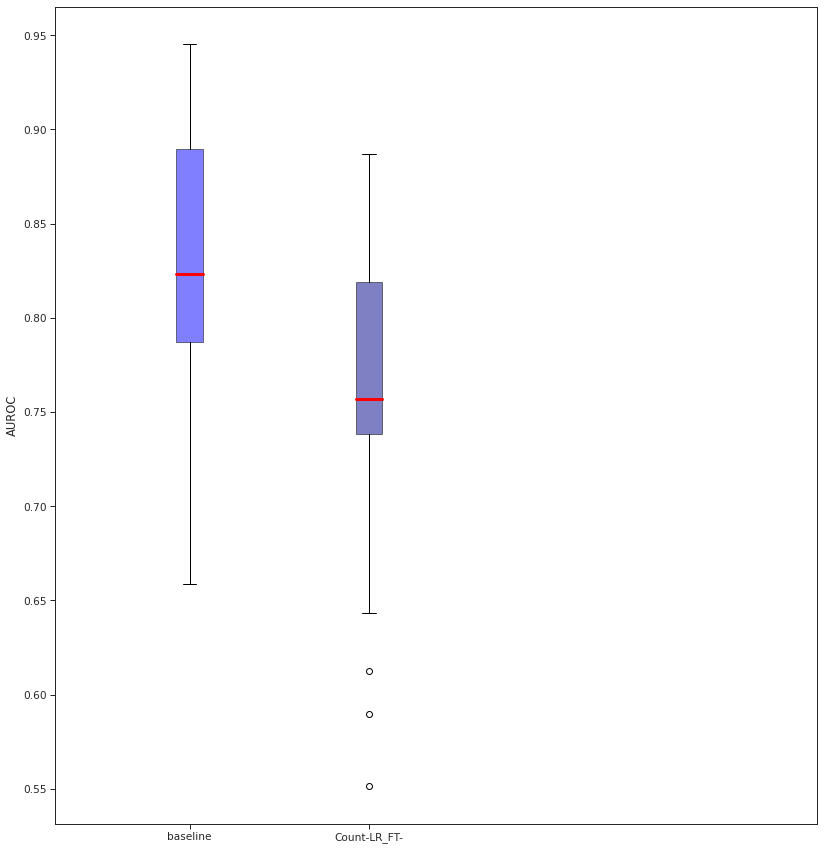

In [39]:
metrics = ['auc']
colours = ['blue', 'darkblue', 'yellow']
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(12,15))
plt.tight_layout(w_pad=1,h_pad=0.5,rect=[0.05,0.15,1,0.95])

fg = 'shared'

for r, metric in enumerate(metrics):
#     bl = np.array(bl_lr_df.query("test_group=='test' and metric=='auc' and feature_group=='shared' and cohort=='pediatric' and metric==@metric")['CI_med'])
    lr_bl = list(lr_df.query("train_cohort=='pediatric' and metric=='auc' and feature_group=='shared' and metric==@metric")['performance'])
    
    lr_naive = list(lr_df.query("train_cohort=='adult' and metric=='auc' and feature_group=='shared' and metric==@metric")['performance'])
#     lr_ft = list(ft_lr_df.query("test_group=='test' and metric=='auc' and feature_group=='shared' and cohort=='adult' and metric==@metric")['CI_med'])
#     clmbr_naive = list(pt_clmbr_df.query("phase=='test' and metric=='auc' and cohort=='all' and metric==@metric")['CI_med'])
#     clmbr_ft = list(ft_clmbr_df.query("test_group=='test' and metric=='auc' and cohort=='all' and metric==@metric")['CI_med'])
    #bp = axes.boxplot([lr_naive, lr_ft, clmbr_naive], positions=[2,4,6], labels=['Count-LR_FT-', 'Count-LR_FT+', 'CLMBR_FT-'], patch_artist=True)
    bp = axes.boxplot([lr_bl,lr_naive], positions=[2,4], labels=['baseline','Count-LR_FT-'], patch_artist=True)
    for patch, colour in zip(bp['boxes'], colours):
        patch.set_facecolor(colour)
        patch.set_alpha(0.5)
        
    for median in bp['medians']:
        median.set(color ='red', linewidth = 3)
    
#     bl_line = axes.plot([0.5, 9],[bl_med, bl_med], linestyle='dashed', color='black', zorder=0)
#     axes.plot([0.5, 9],[bl_min, bl_min], linestyle='dotted', color='black', zorder=0)
#     axes.plot([0.5, 9],[bl_max, bl_max], linestyle='dotted', color='black', zorder=0)
    axes.set_ylabel(y_axis[metric]['label'])
    plt.xlim([0.5,9])
#     for c, task in enumerate(tasks):

In [40]:
print(len(tasks))

31
